# Progression of COVID-19 spread
> Some visuals using Open public API

- toc: false
- badges: true
- comments: true
- categories: [coswara,tutorial,covid]
- image: images/chart-preview.png
- author: Neeraj Sharma

# Visualizing across countries 

The WHO provides daily updates from 252 countries. This data can be accessed from a CSV file. Below we read this file from a url and show some visualizations.

## First, the daily COVID-19 case count ....

Load packages ...

In [1]:
# collapse
import numpy as np
import librosa 
import matplotlib.pyplot as plt
import pickle
from PyEMD import EMD
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import datetime
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import json
import requests
import seaborn as sns

sns.set(style="ticks")


Load data ...

In [2]:
#collapse
url = 'https://covid19.who.int/WHO-COVID-19-global-data.csv'
df = pd.read_csv(url)

# get the dates
dates = df['Date_reported'].unique()
dates = [datetime.datetime.strptime(ts, "%Y-%m-%d") for ts in dates]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%Y-%m-%d") for ts in dates]

# accummulate across countries for each date
data_1 = []
data_2 = []
for i in range(len(dates)):
    data_1.append(np.sum(df.loc[df['Date_reported']==sorteddates[i]]['Cumulative_deaths'].values))
    data_2.append(np.sum(df.loc[df['Date_reported']==sorteddates[i]]['Cumulative_cases'].values))

# read country-wise daily cases into a np.array
countries = df['Country'].unique()
all_country = np.zeros((len(countries),len(sorteddates)))
for i in range(len(countries)):
    temp = df[df['Country']==countries[i]]
    for j in range(len(sorteddates)):
        temp_1 = temp[temp['Date_reported']==sorteddates[j]]
        if len(temp_1):
            all_country[i,j] = temp_1['New_cases']


Make plot ...

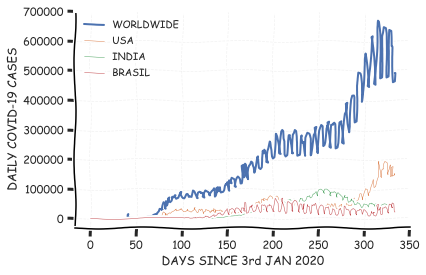

In [3]:
#collapse
# plot daily cases time series
fig = plt.subplots(figsize=[6,4])
plt.xkcd()
ax = plt.subplot(1,1,1)

clr_1 = 'tab:blue'
ax.plot(np.sum(all_country,axis=0),label='WORLDWIDE')
ax.plot(all_country[np.where(countries=='United States of America')[0][0],:],label='USA',linewidth=.5)
ax.plot(all_country[np.where(countries=='India')[0][0],:],label='INDIA',linewidth=.5)
ax.plot(all_country[np.where(countries=='Brazil')[0][0],:],label='BRASIL',linewidth=.5)
ax.legend(loc='upper left',fontsize=10,frameon=False)
ax.grid(axis='both', color='gray', linestyle='--', linewidth=.75,alpha=.1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('DAYS SINCE 3rd JAN 2020')
ax.set_ylabel('DAILY COVID-19 CASES')
# fmt = 'png'
# plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
#                   +'covid_trace_spectrum.'+fmt, dpi=300, format=fmt,transparent=False,bbox_inches='tight')
plt.show()

Did you notice the oscillatory behavior in the traces shown in the above figure? What are those! We can take a quick Fourier transform of the global trace, and may be that can help us understand something? The below code does this. We see two nice peaks in the Fourier magnitude spectrum. These reside at 1/7 and 2/7 (are harmonics!). Bingo, so the oscillatory behavior relates to the weekly data reporting pattern. There is a dip in the daily case reporting (or tests) on weekends. Interestingly, this pattern is there across many countries, and when we sum across all countries, we see the pattern in the world-wide daily cases COVID trace as well. In short, all nations have weekends, they fall on the same days, and we behave in similar fashion on those days ... atleast in terms of the dip in the COVID-19 cases. 

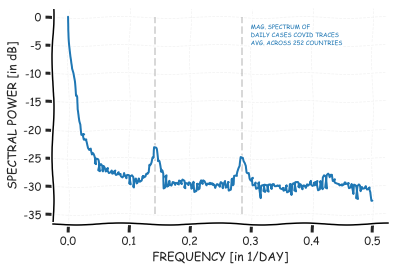

In [4]:
#collapse
S = []
for i in range(all_country.shape[0]):
#     s = all_country[np.where(countries=='United States of America')[0][0],:]
    s = np.nan_to_num(all_country[i,:])+1e-10
    s[s<0] = 0
    s = s/np.max(np.abs(s))
    S.append(s)

# take fft
nfft = 512
S = np.array(S)
S_fft = np.abs(np.fft.rfft(S,nfft,axis=1))
# normalize
for i in range(S.shape[0]):
    S_fft[i,:] = S_fft[i,:]/(np.max(S_fft[i,:])+10e-10)
#mean and std 
S_fft = 20*np.log10(S_fft+10e-20)
S_mu = np.mean(S_fft,axis=0)
S_std = np.std(S_fft,axis=0)/np.sqrt(all_country.shape[0])


# plot spectrum
fig = plt.subplots(figsize=[6,4])
ax = plt.subplot(1,1,1)

fs = 1
faxis = np.arange(0,nfft/2+1)*fs/nfft
clr_1 = 'tab:blue'
ax.plot(faxis,S_mu,c=clr_1,linewidth=2)
# ax.plot(faxis,S_mu - S_std,color='r',alpha=.3,linewidth=.5)
# ax.plot(faxis,S_mu + S_std,color='r',alpha=.3,linewidth=.5)
ax.vlines(1/7, -35, 0, colors='gray', linestyles='--',alpha=.3)
ax.vlines(2/7, -35, 0, colors='gray', linestyles='--',alpha=.3)
ax.grid(axis='both', color='gray', linestyle='--', linewidth=.75,alpha=.1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('FREQUENCY [in 1/DAY]')
ax.set_ylabel('SPECTRAL POWER [in dB]')
ax.text(.3,-5,'MAG. SPECTRUM OF \nDAILY CASES COVID TRACES \nAVG. ACROSS 252 COUNTRIES',\
       c=clr_1,fontsize=6)
fmt = 'png'
# plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
#                   +'covid_trace_time_domain.'+fmt, dpi=300, format=fmt,transparent=False,bbox_inches='tight')
plt.show()



## Second, how does the cummulative cases look?
As seen in the trace below, as of 3rd Dec 2020, it is still increasing.

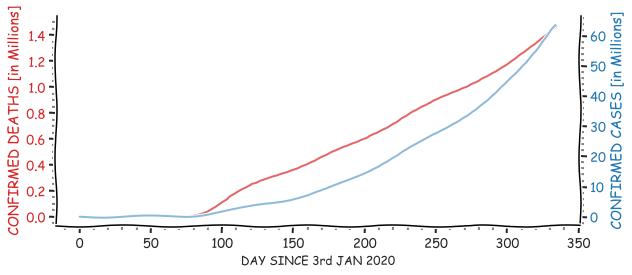

In [5]:
#collapse
# Create some mock data
fig, ax1 = plt.subplots(figsize=(9,4))

color = 'tab:red'
ax1.set_xlabel('DAY SINCE 3rd JAN 2020')
ax1.set_ylabel('CONFIRMED DEATHS [in Millions]', color=color, fontsize=14)
ax1.plot(np.array(data_1)/1e6, '-',color=color,alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.spines['top'].set_visible(False)
ax1.grid(True)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4, color='gray')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.xticks([0,31,60,91,len(sorteddates)-1],\
#            ['11 Jan','11 Feb','11 Mar','11 Apr','16 May 2020'],rotation=0)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('CONFIRMED CASES [in Millions]', color=color,fontsize=14)  # we already handled the x-label with ax1
ax2.plot(np.array(data_2)/1e6,'-', color=color,alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['top'].set_visible(False)
ax1.grid(True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=7)
ax2.tick_params(which='minor', length=4, color='gray')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.xticks([0,31,60,91,len(sorteddates)-1],\
#            ['11 Jan','11 Feb','11 Mar','11 Apr','16 May 2020'],rotation=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig(path_store_figure+"IS2020_coswara_covid_who.pdf", bbox_inches='tight')
plt.show()

# Visualizing data from India 

We use the API hosted by www.covid19india.org for this. We first obtain the daily case count from it. Below is the code.

In [8]:
#collapse
resp = requests.get('https://api.covid19india.org/data.json')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    
    
daily_testing = {}
daily_testing['totalsamplestested'] = []
daily_testing['samplereportedtoday'] = []
daily_testing['date'] = []

for item in resp.json()['tested']:
    if item['totalsamplestested']!='':
        daily_testing['totalsamplestested'].append(int(item['totalsamplestested']))
    else:
        daily_testing['totalsamplestested'].append(0)
    daily_testing['date'].append(item['updatetimestamp'])

daily_cases = {}
daily_cases['dailyconfirmed'] = []
daily_cases['dailydeceased'] = []
daily_cases['dailyrecovered'] = []
daily_cases['date'] = []

for item in resp.json()['cases_time_series']:
    daily_cases['dailyconfirmed'].append(int(item['dailyconfirmed']))
    daily_cases['dailydeceased'].append(int(item['dailydeceased']))
    daily_cases['dailyrecovered'].append(int(item['dailyrecovered']))
    daily_cases['date'].append(item['date'])
    
total_cases = {}
total_cases['totalconfirmed'] = []
total_cases['totaldeceased'] = []
total_cases['totalrecovered'] = []
total_cases['date'] = []

for item in resp.json()['cases_time_series']:
    total_cases['totalconfirmed'].append(int(item['totalconfirmed']))
    total_cases['totaldeceased'].append(int(item['totaldeceased']))
    total_cases['totalrecovered'].append(int(item['totalrecovered']))
    total_cases['date'].append(item['date'])


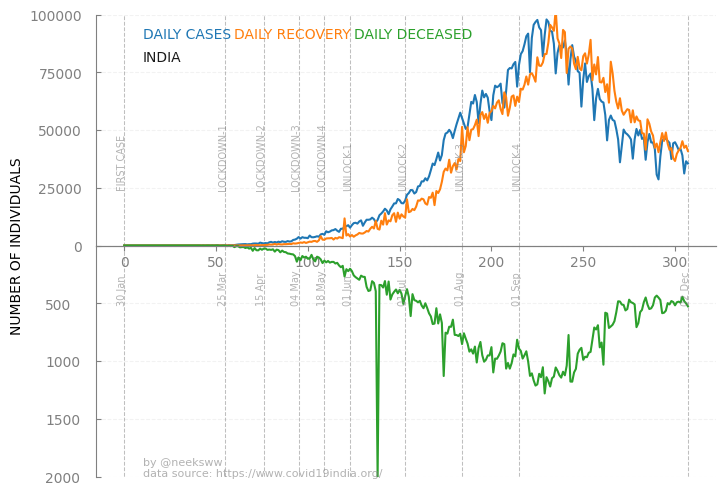

In [9]:
# collapse
fig = plt.subplots(figsize=(8,6))
clr_1 = "tab:blue"
clr_2 = "tab:orange"
clr_3 = "tab:green"

mpl.rcParams.update(mpl.rcParamsDefault)
ax1 = plt.subplot(1,1,1)
ax1.plot(np.arange(0,len(daily_cases['dailyconfirmed']),1),daily_cases['dailyconfirmed'],\
         color=clr_1,label='DAILY CASES')
ax1.plot(np.arange(0,len(daily_cases['dailyrecovered']),1),daily_cases['dailyrecovered'],\
         color=clr_2,label='DAILY RECOVERED')
ax1.grid(axis='y', color='gray', linestyle='--', linewidth=.75,alpha=.1)
# # for i in range(len(daily_cases['dailyrecovered'])):
# #     ax.hlines(daily_cases['dailyrecovered'][i],i-14,i,colors='grey', linestyles='solid',alpha=0.3)
# ax1.xaxis.set_minor_locator(AutoMinorLocator())
# ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.spines['top'].set_color('none')
ax1.spines['bottom'].set_position('center')
ax1.spines["left"].set_bounds(0, 100000)
ax1.spines["left"].set_color('gray')
ax1.spines["right"].set_bounds(0, 0)
ax1.spines['bottom'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
ax1.tick_params(axis='x', colors='gray')

ax1.set_yticks(np.arange(0, 100001,25000)) 
ax1.set_ylim([-100000,100000])
ax1.text(10,80000,'INDIA',fontsize=10,color='k')
ax1.text(10,90000,'DAILY CASES',fontsize=10,color=clr_1)
ax1.text(60,90000,'DAILY RECOVERY',fontsize=10,color=clr_2)
ax1.text(125,90000,'DAILY DECEASED',fontsize=10,color=clr_3)
ax1.tick_params(axis='y', colors='gray',direction='out')



ax2 = ax1.twinx()  
color = 'tab:red'
ax2.plot(np.arange(0,len(daily_cases['dailyconfirmed'])),[i for i in daily_cases['dailydeceased']],
         color=clr_3,label='DAILY DECEASED')
ax2.grid(axis='y',color='gray', linestyle='--', linewidth=.75,alpha=.1)
# ax2.xaxis.set_minor_locator(AutoMinorLocator())
# ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_position('center')
ax2.spines["left"].set_bounds(0, 2000)
ax2.spines["left"].set_bounds(0, 0)
ax2.spines["right"].set_bounds(0, 2000)
ax2.spines["right"].set_position(('axes',0))
ax2.spines['bottom'].set_color('gray')
ax2.spines["right"].set_color('gray')
ax2.tick_params(axis='x', colors='gray')

ax2.set_yticks(np.arange(0,2100,500)[1:]) 
ax2.set_ylim([-2000,2000])
plt.gca().invert_yaxis()
ax1.tick_params(axis='y', colors='gray',direction='in', pad=10)
ax2.tick_params(axis='y', colors='gray',direction='out', pad=-40)


xticks = [0,55,76,95,109,123,153,184,215,len(total_cases['totalconfirmed'])-1]
cnt = 0
str_lock = ['FIRST CASE','LOCKDOWN-1','LOCKDOWN-2','LOCKDOWN-3','LOCKDOWN-4','UNLOCK-1','UNLOCK-2','UNLOCK-3'\
            ,'UNLOCK-4',' ']
xlabels = []
ind_1 = 6
for i in xticks:
    ax1.vlines(i,min(total_cases['totaldeceased']),max(total_cases['totaldeceased']),
              linestyles ="--", colors ="gray",alpha=0.5,linewidth=.75)
    ax2.vlines(i,min(total_cases['totaldeceased']),max(total_cases['totaldeceased']),
              linestyles ="--", colors ="gray",alpha=0.5,linewidth=.75)
    ax1.text(i-4,25000,str_lock[cnt],rotation=90,fontsize=7,color='gray',alpha=0.6)
    if  i == len(total_cases['totalconfirmed']):
        xlabels.append(total_cases['date'][-1][:ind_1])
    else:
        xlabels.append(total_cases['date'][xticks[cnt]][:ind_1])
    ax2.text(i-4,500,xlabels[cnt],rotation=90,fontsize=7,color='gray',alpha=0.6)
    cnt = cnt+1
ax1.set_ylabel('NUMBER OF INDIVIDUALS',fontsize=10)
ax2.text(10,1900,'by @neeksww',fontsize=8,color='gray',alpha=0.6)
ax2.text(10,2000,'data source: https://www.covid19india.org/',fontsize=8,color='gray',alpha=0.6)

fmt = 'png'
plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
                  +'covid_status_whole_india.'+fmt, dpi=300, format=fmt,transparent=False,bbox_inches='tight')
plt.show()

## Which day of week reports the maximum case ... Monday ?

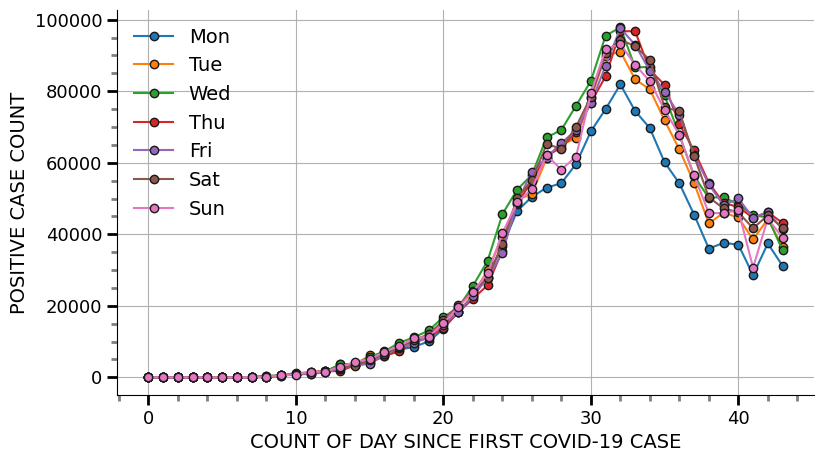

In [10]:
#collapse
dataset = {}

dataset['month'] = []
dataset['day'] = []
dataset['year'] = []

dataset['dailyconfirmed'] = daily_cases['dailyconfirmed']
dataset['dailyrecovered'] = daily_cases['dailyrecovered']
dataset['dailydeceased'] = daily_cases['dailydeceased']

# date creation
for date in total_cases['date']:
    day = int(date.split(' ' )[0])
    month = date.split(' ')[1]
    if month == 'January':
        month_val = 1
    if month == 'February':
        month_val = 2
    if month == 'March':
        month_val = 3
    if month == 'April':
        month_val = 4
    if month == 'May':
        month_val = 5
    if month == 'June':
        month_val = 6
    if month == 'July':
        month_val = 7
    if month == 'August':
        month_val = 8
    if month == 'September':
        month_val = 9
    if month == 'October':
        month_val = 10
    if month == 'November':
        month_val = 11
    if month == 'December':
        month_val = 12
    year_val = 2020
    day_val = datetime.datetime(year_val, month_val, day).strftime("%A")
    # push into dict
    dataset['day'].append(day_val)
    dataset['month'].append(month_val)
    dataset['year'].append(year_val)
    
df = pd.DataFrame.from_dict(dataset)
label_day = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig = plt.subplots(figsize=[9,5])
ax = plt.subplot(1,1,1)
day_mu = []
for i in label_day:
#     if i == 'Monday' or i == 'Saturday':
        temp = df[df['day']==i]['dailyconfirmed'].values
        ax.plot(temp,'-',label=i[:3],marker='o',markeredgecolor='k')
        day_mu.append(np.mean(df[df['day']==i]['dailyconfirmed']))
        ax.grid(True)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
ax1.grid(color='gray', linestyle='--', linewidth=1,alpha=.1)
ax.set_xlabel('COUNT OF DAY SINCE FIRST COVID-19 CASE',fontsize=14)
ax.set_ylabel('POSITIVE CASE COUNT',fontsize=14)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='gray')
ax.legend(frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

# Visualizing India state-wise data
Load csv ...

In [ ]:
#collapse
df = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')

Make the plot ...

In [ ]:
#collapse
# temp_1 = normalize(temp_1,norm='max', axis=0)
state_labels = ['KA','TN','MH','DL','GJ','KL']
state_labels = ['MH','KA','AP','UP','TN','RJ','TG','AS','CH','KL','DL','BR',\
                'GJ','OR','WB','HR','JK','HP','MP','PB','NL','GA','JH','AN',\
                'MN','ML','SK','TR',
               ]
state_labels_= ['MH','KA','AP','UP','TN','RJ','TS','AS','CG','KL','DL','BR',\
                'GJ','OD','WB','HR','JK','HP','MP','PB','NL','GA','JH','AN',\
                'MN','ML','SK','TR'
               ]



clr_1 = 'tab:blue'
clr_2 = 'tab:orange'

cnt = 0
start_cases = []
start_decea = []
current_cases = []

for i in state_labels:
    cnt+= 1
    start_cases.append(np.where(np.cumsum(df[df['Status']=='Confirmed'][i].values)>5)[0][0])
    start_decea.append(np.where(np.cumsum(df[df['Status']=='Deceased'][i].values)>5)[0][0])
    current_cases.append(df[df['Status']=='Confirmed'][i].values[-1])

indx = np.argsort(current_cases)[::-1]   

fig = plt.subplots(figsize=[20,40])
cnt = 0
all_states_cases = []
all_states_decea = []

plt.xkcd()
for i in indx:
    cnt+= 1
    ax1 = plt.subplot(7,4,cnt)
    ax2 = ax1.twinx()  
    
    temp_1 = medfilt(df[df['Status']=='Confirmed'][state_labels[i]].values,3)
    all_states_cases.append(temp_1/max(temp_1))
#     temp_1 = savgol_filter(df[df['Status']=='Confirmed'][state_labels[i]].values,window_length=7, polyorder=1,\
#                            deriv=0, delta=1.0, axis=0, mode='nearest')
    
    temp_2 = medfilt(df[df['Status']=='Deceased'][state_labels[i]].values,3)
    all_states_decea.append(temp_2/(max(temp_2)))
#     temp_2 = savgol_filter(df[df['Status']=='Deceased'][state_labels[i]].values,window_length=7, polyorder=1,\
#                            deriv=0, delta=1.0, axis=0, mode='nearest')

    ax1.plot(np.arange(0,len(temp_1),1),temp_1,color=clr_1, linewidth=3)
    ax1.spines['right'].set_color('none')
    ax1.spines['left'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.spines['bottom'].set_color('gray')
    ax1.tick_params(axis='y', colors=clr_1)
    ax2.tick_params(axis='x', colors='gray')
    ax1.text(0,max(temp_1)-0.0*max(temp_1),'Indian State: '+state_labels_[i],fontsize=12,color='tab:red',alpha=0.9,
            fontweight='bold')
#     ,\bbox=dict(facecolor='gray', alpha=0.2))
    ax1.text(0,max(temp_1)-0.1*max(temp_1),'daily cases',fontsize=14,color=clr_1)
    ax1.text(0,max(temp_1)-0.15*max(temp_1),'daily deceased',fontsize=14,color=clr_2)
    ax1.text(0,max(temp_1)-0.3*max(temp_1),'For days since:\n'+ df['Date'][0].split('-20')[0] +' to '+\
             df['Date'][len(df)-1].split('-20')[0],fontsize=14,color='black',alpha=0.75)
    ax1.text(0,max(temp_1)-0.5*max(temp_1),'With three sample\n median filtered',fontsize=10,color='gray',
                 rotation=0,alpha=0.6)
    ax1.text(0,max(temp_1)-0.9*max(temp_1),'data source:\n https://www.covid19india.org/',fontsize=10,color='gray',
                 rotation=0,alpha=0.4)
    if cnt == 4:
        ax1.text(len(temp_1)-10,0,'@neeksww',fontsize=14,color='gray',
                 rotation=90,alpha=0.3)
    ax1.grid(color='gray', linestyle='--', linewidth=1,alpha=.1)
    
    ax2.plot(np.arange(0,len(temp_2),1),temp_2,color=clr_2, linewidth=3)
    ax2.tick_params(axis='x', labelcolor=clr_2)    
    ax2.spines['top'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['left'].set_color('none')
    ax2.spines['bottom'].set_color('gray')
    ax2.tick_params(axis='y', colors=clr_2)

#     clr_face = (79/256,178/256,151/256)
#     ax1.set_facecolor(clr_face)
#     ax2.set_facecolor(clr_face)
# fmt = 'png'
# plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
#                   +'covid_status_india.'+fmt, dpi=300, format=fmt,transparent=False,bbox_inches='tight')
plt.show()